#Yelp NLP

##Phase I - Pre-processing the data:

###Objectives in this phase:
The main objective of this phase is **exploratory data analysis**. We do that by analysing each attribute and,
1. Look at the distribution (in case of numerical attribute)
2. Standardize the data (in case of numerical attribute)
3. Convert categorical data to numerical data
4. Identify the output variable(s)
5. Feature Engineering (removing redundant data features, finding dependent features)
    - PCA - finding independent and uncorrelated features that have significant variance
    - summarizing or clustering data with not much variance
6. Visualizing the data
    - histograms
    - scatter plot of output vs each attribute
7. Identify the features among the attributes

###Splitting the dataset into small chunks:
First, we split the large dataset into small chunks as separate files. Primarily, user.json and review.json are huge files that requires a lot of RAM. Splitting the files enables us to load one fold at a time, thereby, reducing the load on memory.

In [19]:
import sys
import os

#setting up path to dataset
user_json = os.path.join("..","data","user.json")
user_data_dir = os.path.join("..","data","user")
review_json = os.path.join("..","data","review.json")
review_data_dir = os.path.join("..","data","review")

In [6]:
import csv
import json

def convert_review_to_csv(json_file_path, out_dir, lines_per_file):
    columns = ['user_id','business_id','text','stars','useful','funny','cool']
    json_file = open(json_file_path, 'r')
    count = 0
    fname = 1
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    output = csv.writer(open(os.path.join(out_dir,str(fname)+".csv"), "w+"))
    output.writerow(columns)
    for line in json_file:
        count += 1
        j = json.loads(line)
        j['text'] = j['text'].replace("\n"," ")
        csv_arr = list()
        for column in columns:
            if column in j:
                csv_arr.append(j[column])
        output.writerow(csv_arr)
        if count == lines_per_file:
            count = 0
            fname += 1
            output = csv.writer(open(os.path.join(out_dir,str(fname)+".csv"), "w+"))
    json_file.close()
    
print("Converting review json to chunks of csv files...")
review_json = os.path.join("..","data","review.json")
review_csv_dir = os.path.join("..","data","review_csv")
convert_review_to_csv(json_file_path=review_json, out_dir=review_csv_dir, lines_per_file=50000)
print("Done")

Converting review json to chunks of csv files...
Done


In [7]:
import csv
import json

def convert_user_to_csv(json_file_path, out_dir, lines_per_file):
    columns = ['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny', 'cool', 
               'fans', 'elite', 'average_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 
               'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 
               'compliment_funny', 'compliment_writer', 'compliment_photos']
    json_file = open(json_file_path, 'r')
    count = 0
    fname = 1
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    output = csv.writer(open(os.path.join(out_dir,str(fname)+".csv"), "w+"))
    output.writerow(columns)
    for line in json_file:
        count += 1
        j = json.loads(line)
        csv_arr = list()
        for column in columns:
            if column in j:
                csv_arr.append(j[column])
        output.writerow(csv_arr)
        if count == lines_per_file:
            count = 0
            fname += 1
            output = csv.writer(open(os.path.join(out_dir,str(fname)+".csv"), "w+"))
    json_file.close()
    
print("Converting user json to chunks of csv files...")
user_json = os.path.join("..","data","user.json")
user_csv_dir = os.path.join("..","data","user_csv")
convert_user_to_csv(json_file_path=user_json, out_dir=user_csv_dir, lines_per_file=50000)
print("Done")

Converting user json to chunks of csv files...
Done


In [8]:
import csv
import json

def convert_business_to_csv(json_file_path, out_dir, lines_per_file):
    columns = ['business_id','name','address','city','state','postal_code','latitude','longitude','stars']
    json_file = open(json_file_path, 'r')
    count = 0
    fname = 1
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    output = csv.writer(open(os.path.join(out_dir,str(fname)+".csv"), "w+"))
    output.writerow(columns)
    for line in json_file:
        count += 1
        j = json.loads(line)
        csv_arr = list()
        for column in columns:
            if column in j:
                csv_arr.append(j[column])
        output.writerow(csv_arr)
        if count == lines_per_file:
            count = 0
#             output.close()
            fname += 1
            output = csv.writer(open(os.path.join(out_dir,str(fname)+".csv"), "w+"))
#     output.close()
    json_file.close()
    
print("Converting business json to chunks of csv files...")
biz_json = os.path.join("..","data","business.json")
biz_csv_dir = os.path.join("..","data","biz_csv")
convert_business_to_csv(json_file_path=biz_json, out_dir=biz_csv_dir, lines_per_file=50000)
print("Done")

Converting business json to chunks of csv files...
Done


In [5]:
#utility to get a summary of the dataset...
import os
import json 

def get_summary(file_path):
    file = open(file_path, 'r')
    line = json.loads(file.readline())
    attributes = list(line.keys())
    count = 1
    for line in file:
        count+=1
    file.close()

    return (count,attributes)

summary = get_summary(os.path.join("..","data","review.json"))
print("Summary of review.json :")
print("Total number of records: "+str(summary[0]))
print("Attributes: ",summary[1])

summary = get_summary(os.path.join("..","data","user.json"))
print("\nSummary of user.json :")
print("Total number of records: "+str(summary[0]))
print("Attributes: ",summary[1])

summary = get_summary(os.path.join("..","data","business.json"))
print("\nSummary of business.json :")
print("Total number of records: "+str(summary[0]))
print("Attributes: ",summary[1])

Summary of review.json :
Total number of records: 4736897
Attributes:  ['review_id', 'user_id', 'business_id', 'stars', 'date', 'text', 'useful', 'funny', 'cool']

Summary of user.json :
Total number of records: 1183362
Attributes:  ['user_id', 'name', 'review_count', 'yelping_since', 'friends', 'useful', 'funny', 'cool', 'fans', 'elite', 'average_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos']

Summary of business.json :
Total number of records: 156639
Attributes:  ['business_id', 'name', 'neighborhood', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']


##Data Distribution Charts:
- Number of reviews per year (trend chart)
- Number of users who joined yelp per year

- Number of useful, cool and funny reviews per business (there are nearly 156639 businesses. Takes a lot of time to render graph)
- Number of reviews per business (there are nearly 156639 businesses. Takes a lot of time to render graph)

- Number of reviews per possible rating value

####Rating vs Number of reviews:

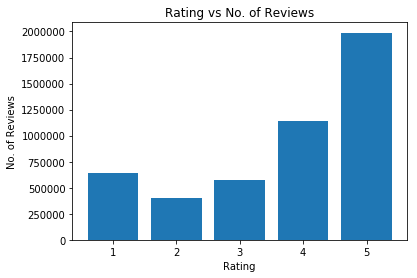

In [47]:
import json
import matplotlib.pyplot as plotter

def reviews_vs_rating(file_path):
    rating = [0,0,0,0,0,0]
    file = open(file_path, 'r')
    for line in file:
        j = json.loads(line)
        rating[j["stars"]]+=1
    file.close()
    return rating

ratings = reviews_vs_rating(os.path.join("..","data","review.json"))
plotter.bar([1,2,3,4,5],ratings[1:])
plotter.xlabel('Rating')
plotter.ylabel('No. of Reviews')
plotter.title('Rating vs No. of Reviews')
plotter.show()

In [2]:
# import os
# import json


# def reviews_vs_business(file_path):
#     business = dict()
#     file = open(file_path, 'r')
#     for line in file:
#         j = json.loads(line)
#         if j["business_id"] in business:
#             business[j["business_id"]] += 1
#         else:
#             business[j["business_id"]] = 1
#     file.close()
#     return business

# print("Finding business vs reviews")
# businesses = reviews_vs_business(os.path.join("..","data","review.json"))
# print("Processed file... Drawing graph.")

Finding business vs reviews
Processed file... Drawing graph.


In [11]:
# import matplotlib.pyplot as plotter

# l = list(businesses.keys())
# for i in range(16):
#     plotter.bar(range(9214),[businesses[id] for id in l[(9214*i):(9214*(i+1))]])
#     plotter.xticks(range(9214), l[(9214*i):(9214*(i+1))])
#     plotter.xlabel('Business')
#     plotter.ylabel('No. of Reviews')
#     plotter.title('Business vs No. of Reviews')
#     plotter.show()

# # 9214
# print("Done")

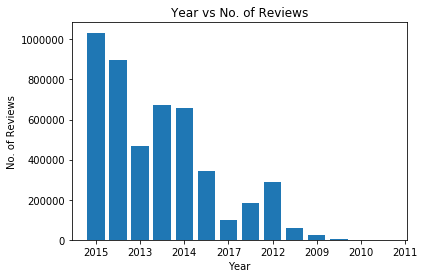

In [23]:
import json
import matplotlib.pyplot as plotter

def reviews_vs_date(file_path):
    dates = dict()
    file = open(file_path, 'r')
    for line in file:
        j = json.loads(line)
        d = j["date"][0:4]
        if d in dates:
            dates[d] += 1
        else:
            dates[d] = 1
    file.close()
    return dates

dates = reviews_vs_date(os.path.join("..","data","review.json"))

ax = plotter.subplot(111)
ax.bar(range(len(dates.keys())),list(dates.values()))
ax.set_xticklabels(dates.keys())
plotter.xlabel('Year')
plotter.ylabel('No. of Reviews')
plotter.title('Year vs No. of Reviews')
plotter.show()

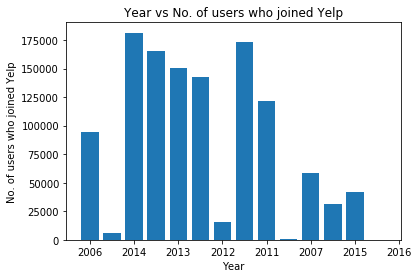

In [20]:
import json
import matplotlib.pyplot as plotter

def reviews_vs_date(file_path):
    dates = dict()
    file = open(file_path, 'r')
    for line in file:
        j = json.loads(line)
        d = j["yelping_since"][0:4]
        if d in dates:
            dates[d] += 1
        else:
            dates[d] = 1
    file.close()
    return dates

dates = reviews_vs_date(os.path.join("..","data","user.json"))

ax = plotter.subplot(111)
ax.bar(range(len(dates.keys())),list(dates.values()))
ax.set_xticklabels(dates.keys())
plotter.xlabel('Year')
plotter.ylabel('No. of users who joined Yelp')
plotter.title('Year vs No. of users who joined Yelp')
plotter.show()